## STAT451 Project: IMDb movie review classification and prediction

**Group 12: Isabella Xue, Freya Wan, Shuyuan Jia :)**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import ssl
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

In [2]:
# set the font globally
plt.rcParams.update({'font.family':'sans-serif'})


In [3]:
df = pd.read_csv('IMDB Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

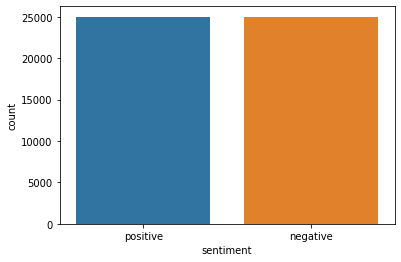

In [5]:
import seaborn as sn
sn.countplot(x="sentiment",data=df)

In [6]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

We can see that this dataset is balanced. The number of positive reviews and negative reviews are equal.

**Data Cleaning**

In [7]:
# !pip install contractions
import contractions  # This package is used to replace the contractions in English language with their actual forms
from tqdm import tqdm  # tqdm is used to display the percentage of work done by a for loop.
import nltk
import re
import time
#ssl._create_default_https_context = ssl._create_unverified_context
#nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords=stopwords.words('english')
# Removing stopwords 'no','nor' and 'not'
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

df['label'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head(10)

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1
7,"This show was an amazing, fresh & innovative i...",negative,0
8,Encouraged by the positive comments about this...,negative,0
9,If you like original gut wrenching laughter yo...,positive,1


In [8]:
clean_reviews=[]

for i in tqdm(df['review']):
    # Regular expression that removes all the html tags pressent in the reviews
    i = re.sub('(<[\w\s]*/?>)',"",i)
    # Expanding all the contractions present in the review to is respective actual form
    i = contractions.fix(i)
    # Removing all the special charactesrs from the review text
    i = re.sub('[^a-zA-Z0-9\s]+',"",i)
    # Removing all the digits present in the review text
    i = re.sub('\d+',"",i)
    # processed_reviews.append(" ".join([lemmatizer.lemmatize(j.lower()) for j in i.split() if j not in stopwords and len(j)>=3]))
    clean_reviews.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

100%|██████████| 50000/50000 [00:25<00:00, 1959.35it/s]


In [9]:
# Create a new datafram using the clean_reviews
new_clean_df = pd.DataFrame({'review':clean_reviews,'label':list(df['label'])})
new_clean_df.head()

,review,label
0,one reviewers mentioned watching episode hooke...,1
1,wonderful little production the filming techni...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1


In [10]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stemmer(text):
    final = [porter.stem(word) for word in text.split()]
    return final

In [11]:
# stemmer(new_clean_df['review'][0])

In [12]:
# vectoring by using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, tokenizer = stemmer, use_idf = True, norm ='l2',smooth_idf = True )

In [13]:
Y = new_clean_df['label']
X = tfidf.fit_transform(new_clean_df.review)
# Split the data: 
# 33% data will be used for testing and 67% will be used for training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, Y, stratify = Y, test_size = 0.33)

## Create Baseline Model by using Random Forest

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=123)
clf.fit(x_train, y_train)
rf_t_accuracy = round(clf.score(x_test, y_test), 5)
print(f"Training Accuracy: {clf.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {clf.score(x_test, y_test)*100:0.3f}%")


Training Accuracy: 100.000%
Test Accuracy: 84.994%


Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      8250
           1       0.85      0.85      0.85      8250

    accuracy                           0.85     16500
   macro avg       0.85      0.85      0.85     16500
weighted avg       0.85      0.85      0.85     16500
 



Text(0.5, 1.0, 'RandomForest Confusion matrix')

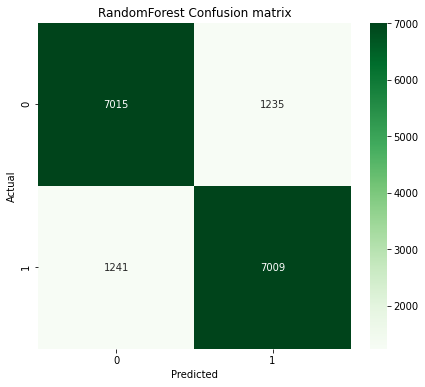

In [15]:
predicted = clf.predict(x_test)
print("Classification report: \n", classification_report(y_test, predicted), "\n")

matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize = (7,6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RandomForest Confusion matrix")

No Skill: ROC AUC=0.500
RandomForest: ROC AUC=0.925


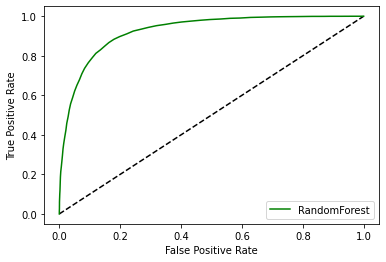

In [16]:
#no skill
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
clf_probs = clf.predict_proba(x_test)
# keep probabilities for the positive outcome only
clf_probs = clf_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
clf_auc = roc_auc_score(y_test, clf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForest: ROC AUC=%.3f' % (clf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(clf_fpr, clf_tpr, color='green', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('RF_roc_curve.png')

## Model selection

### Logistic regression

#### Original ('C': [10, 1.0, 0.1, 100]), validation score: 0.889

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123, max_iter=1000)

params =  {
    'solver':['newton-cg', 'lbfgs', 'sag'],
    'penalty': ['l2', 'l1'],
    'C': [10, 1.0, 0.1, 100]
}

grid = GridSearchCV(estimator=lr_model,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)

grid.fit(x_train, y_train)

grid.best_score_


Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   5.5s
[CV] END .....................C=10, penalty=l2

[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END ................C=0

[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn

0.8893432835820896

In [18]:
lr_model = LogisticRegression(**grid.best_params_)
lr_model.fit(x_train, y_train)
lr_t_accuracy = round(lr_model.score(x_test, y_test), 5)
print(f"Train Accuracy: {lr_model.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lr_model.score(x_test, y_test)*100:0.3f}%")

Train Accuracy: 98.490%
Test Accuracy: 89.133%


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Current ('C': [1.0, 0.1]), validation score=0.88755

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123, max_iter=1000)

params =  {
    'solver':['newton-cg', 'lbfgs', 'sag'],
    'penalty': ['l2', 'l1'],
    'C': [1.0, 0.1]
}

grid = GridSearchCV(estimator=lr_model,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)

grid.fit(x_train, y_train)

grid.best_score_


Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.6s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   2.5s
[CV] END ....................C=1.0, penalty=l2

[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/

0.8863582089552239

In [20]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [21]:
lr_model = LogisticRegression(**grid.best_params_)
lr_model.fit(x_train, y_train)
lr_t_accuracy = round(lr_model.score(x_test, y_test), 5)
print(f"Train Accuracy: {lr_model.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lr_model.score(x_test, y_test)*100:0.3f}%")

Train Accuracy: 92.904%
Test Accuracy: 88.842%


Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      8250
           1       0.88      0.90      0.89      8250

    accuracy                           0.89     16500
   macro avg       0.89      0.89      0.89     16500
weighted avg       0.89      0.89      0.89     16500
 



Text(0.5, 1.0, 'LogisticRegression Confusion matrix')

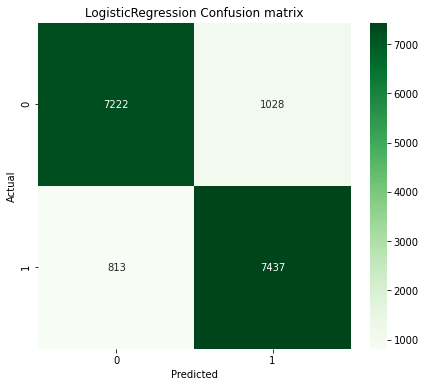

In [22]:
predicted_lr = lr_model.predict(x_test)
print("Classification report: \n", classification_report(y_test, predicted_lr), "\n")

matrix = confusion_matrix(y_test, predicted_lr)
plt.figure(figsize = (7,6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LogisticRegression Confusion matrix")

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.956


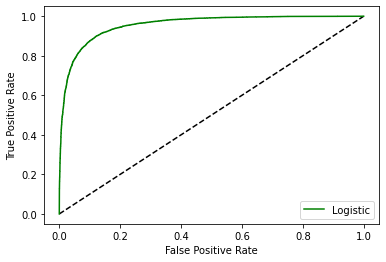

In [23]:
# predict probabilities
lr_probs = lr_model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(lr_fpr, lr_tpr, color='green', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('LR_roc_curve.png')

### XGB

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(random_state=123)
params =  {
    'max_depth':range(4,8,2),
    'min_child_weight': [1,3]
}


grid = GridSearchCV(estimator=xgb,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)

grid.fit(x_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.6s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  18.0s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=1; total time=  17.8s
[CV] END ....................max_depth=4, min_child_weight=3; total time=  17.5s
[CV] END ....................max_depth=4, min_ch

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=123,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [25]:
grid.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [26]:
#xgb = XGBClassifier(random_state=123, max_depth=6, min_child_weight=1)
xgb = XGBClassifier(**grid.best_params_)
xgb.fit(x_train, y_train)
xgb_t_accuracy = round(xgb.score(x_test, y_test), 5)
print(f"Train Accuracy: {xgb.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {xgb.score(x_test, y_test)*100:0.3f}%")

Train Accuracy: 93.910%
Test Accuracy: 85.242%


Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      8250
           1       0.84      0.87      0.85      8250

    accuracy                           0.85     16500
   macro avg       0.85      0.85      0.85     16500
weighted avg       0.85      0.85      0.85     16500
 



Text(0.5, 1.0, 'XGB Confusion matrix')

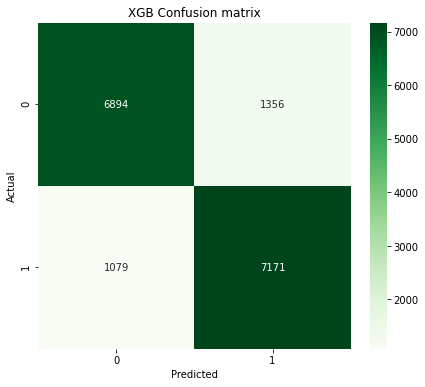

In [27]:
predicted_xgb = xgb.predict(x_test)
print("Classification report: \n", classification_report(y_test, predicted_xgb), "\n")

matrix = confusion_matrix(y_test, predicted_xgb)
plt.figure(figsize = (7,6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGB Confusion matrix")

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.930


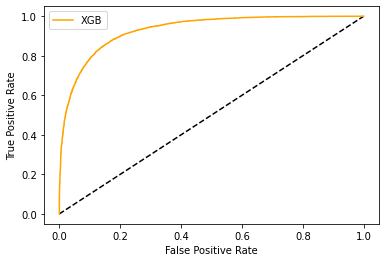

In [28]:
# predict probabilities
xgb_probs = xgb.predict_proba(x_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(xgb_fpr, xgb_tpr, color='orange', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('RF_roc_curve.png')

### LGBMClassifier

In [29]:
import lightgbm as lgb
lboost = lgb.LGBMClassifier(num_leaves=80, bagging_fraction=0.6, bagging_freq=5)
lboost.fit(x_train, y_train)
print(f"Train Accuracy: {lboost.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lboost.score(x_test, y_test)*100:0.3f}%")

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Train Accuracy: 95.400%
Test Accuracy: 86.339%


In [30]:
import lightgbm as lgb
lboost = lgb.LGBMClassifier(num_leaves=80, bagging_fraction=0.6, bagging_freq=5,
                            learning_rate=0.09, num_iterations=200)
lboost.fit(x_train, y_train)
print(f"Train Accuracy: {lboost.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lboost.score(x_test, y_test)*100:0.3f}%")

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Train Accuracy: 98.934%
Test Accuracy: 87.418%


#### Original: have 'num_leaves': [80]
OVERFIT!!

In [31]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
grid_params = {
    'num_leaves': [80],
    'bagging_fraction': [0.6],
    'bagging_freq': [5], 
    'learning_rate' : [0.01,0.05,0.1],
    'num_iterations' : [100,200]}

lboost = lgb.LGBMClassifier()
random_s = RandomizedSearchCV(lboost, grid_params, random_state = 123, n_jobs = -1, verbose = 1)
random_s.fit(x_train,y_train)

print("Best params:")

for key, value in random_s.best_params_.items():
    print(f"\t{key}: {value}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Best params:
	num_leaves: 80
	num_iterations: 200
	learning_rate: 0.1
	bagging_freq: 5
	bagging_fraction: 0.6


In [32]:
lboost_op = lgb.LGBMClassifier(**random_s.best_params_)
lboost_op.fit(x_train, y_train)
lboost_t_accuracy = round(lboost_op.score(x_test, y_test), 5)
print(f"Training Accuracy: {lboost_op.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lboost_op.score(x_test, y_test)*100:0.3f}%")

/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training Accuracy: 99.301%
Test Accuracy: 87.467%


#### Current: NO 'num_leaves': [80]
OVERFIT resolved!!

In [33]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
grid_params = {
    'bagging_fraction': [0.6],
    'bagging_freq': [5], 
    'learning_rate' : [0.01,0.05,0.1],
    'num_iterations' : [100,200]}

lboost = lgb.LGBMClassifier()
random_s = RandomizedSearchCV(lboost, grid_params, random_state = 123, n_jobs = -1, verbose = 1)
random_s.fit(x_train,y_train)

print("Best params:")

for key, value in random_s.best_params_.items():
    print(f"\t{key}: {value}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Best params:
	num_iterations: 200
	learning_rate: 0.1
	bagging_freq: 5
	bagging_fraction: 0.6


In [34]:
lboost_op = lgb.LGBMClassifier(**random_s.best_params_)
lboost_op.fit(x_train, y_train)
#lboost_t_accuracy = round(lboost_op.score(x_test, y_test), 5)
print(f"Training Accuracy: {lboost_op.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {lboost_op.score(x_test, y_test)*100:0.3f}%")

/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training Accuracy: 93.725%
Test Accuracy: 87.218%


Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      8250
           1       0.86      0.88      0.87      8250

    accuracy                           0.87     16500
   macro avg       0.87      0.87      0.87     16500
weighted avg       0.87      0.87      0.87     16500
 



Text(0.5, 1.0, 'lightgbm Confusion matrix')

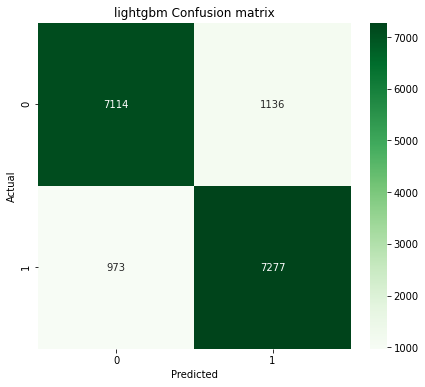

In [35]:
predicted_lb = lboost_op.predict(x_test)
print("Classification report: \n", classification_report(y_test, predicted_lb), "\n")

matrix = confusion_matrix(y_test, predicted_lb)
plt.figure(figsize = (7,6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("lightgbm Confusion matrix")

No Skill: ROC AUC=0.500
LGBM: ROC AUC=0.945


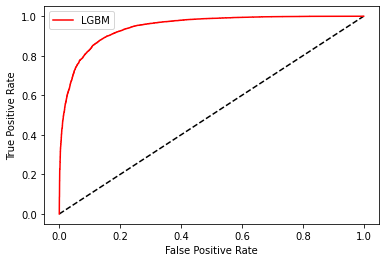

In [36]:
# predict probabilities
lb_probs = lboost_op.predict_proba(x_test)
# keep probabilities for the positive outcome only
lb_probs = lb_probs[:, 1]
# calculate scores
lb_auc = roc_auc_score(y_test, lb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBM: ROC AUC=%.3f' % (lb_auc))
# calculate roc curves
lb_fpr, lb_tpr, _ = roc_curve(y_test, lb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(lb_fpr, lb_tpr, color='red', label='LGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('RF_roc_curve.png')

### Stacking

#### Current 
OVERFITTING resolved!!

In [37]:
from sklearn.ensemble import StackingClassifier
estimators = [('lr_model', lr_model),
              ('xgb', xgb),
              ('lboost_op', lboost)]

sclf = StackingClassifier(estimators=estimators,
                          final_estimator=LogisticRegression(),
                          cv=10)


sclf.fit(x_train, y_train)
print(f"Train Accuracy: {sclf.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {sclf.score(x_test, y_test)*100:0.3f}%")

Train Accuracy: 93.310%
Test Accuracy: 88.909%


In [38]:
stacking_t_accuracy = round(sclf.score(x_test, y_test), 5)

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      8250
           1       0.88      0.90      0.89      8250

    accuracy                           0.89     16500
   macro avg       0.89      0.89      0.89     16500
weighted avg       0.89      0.89      0.89     16500
 



Text(0.5, 1.0, 'Stacking Confusion matrix')

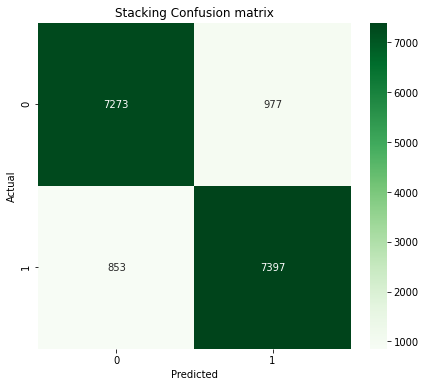

In [39]:
predicted_stac = sclf.predict(x_test)
print("Classification report: \n", classification_report(y_test, predicted_stac), "\n")

matrix = confusion_matrix(y_test, predicted_stac)
plt.figure(figsize = (7,6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Stacking Confusion matrix")

No Skill: ROC AUC=0.500
Stacking: ROC AUC=0.956


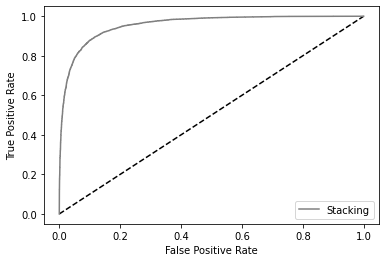

In [40]:
# predict probabilities
stacking_probs = sclf.predict_proba(x_test)
# keep probabilities for the positive outcome only
stacking_probs = stacking_probs[:, 1]
# calculate scores
stacking_auc = roc_auc_score(y_test, stacking_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Stacking: ROC AUC=%.3f' % (stacking_auc))
# calculate roc curves
stacking_fpr, stacking_tpr, _ = roc_curve(y_test, stacking_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(stacking_fpr, stacking_tpr, color='grey', label='Stacking')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('RF_roc_curve.png')

### Voting classifier

In [41]:
eclf = VotingClassifier(estimators=[('lboost_op', lboost_op), ('xgb', xgb), ('lr_model', lr_model)], voting='soft', weights=[2,1,3])
eclf.fit(x_train, y_train) 
print(f"Train Accuracy: {eclf.score(x_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {eclf.score(x_test, y_test)*100:0.3f}%")

/Users/isabellaxue/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Train Accuracy: 94.173%
Test Accuracy: 88.418%


In [42]:
eclf_t_accuracy = round(eclf.score(x_test, y_test), 5)
predicted_voting = eclf.predict(x_test)

No Skill: ROC AUC=0.500
Voting: ROC AUC=0.955


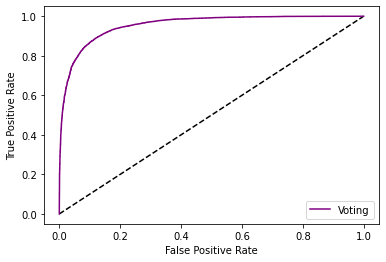

In [43]:
# predict probabilities
voting_probs = eclf.predict_proba(x_test)
# keep probabilities for the positive outcome only
voting_probs = voting_probs[:, 1]
# calculate scores
voting_auc = roc_auc_score(y_test, voting_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Voting: ROC AUC=%.3f' % (voting_auc))
# calculate roc curves
voting_fpr, voting_tpr, _ = roc_curve(y_test, voting_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(voting_fpr, voting_tpr, color='purple', label='Voting')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#plt.savefig('RF_roc_curve.png')

### ROC curve

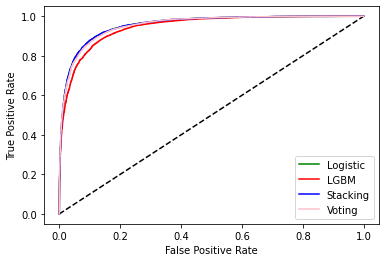

In [44]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, color='black', linestyle='dashed')
plt.plot(lr_fpr, lr_tpr, color='green', label='Logistic')
plt.plot(lb_fpr, lb_tpr, color='red', label='LGBM')
plt.plot(stacking_fpr, stacking_tpr, color='blue', label='Stacking')
plt.plot(voting_fpr, voting_tpr, color='pink', label='Voting')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


## Supervised learning summary table

In [45]:
d = {'Model': ['LogisticRegression','RandomForestClassifier','XGBClassifier', 
               'LGBMClassifier', 'StackingClassifier (Logistic regression, XGB, LGBM)', 
               'VotingClassifier (Logistic regression, XGB, LGBM)'], 
      'Hyperparameter': ['C=1.0, penalty=l2, solver=newton-cg',
                         '-','max_depth=6, min_child_weight=1', 
                         'num_iterations=200, learning_rate=0.1, bagging_freq=5, bagging_fraction=0.6',
                         '-','voting=soft, weights=[3,1,2]'], 
      'Accuracy': [lr_t_accuracy, rf_t_accuracy, xgb_t_accuracy, lboost_t_accuracy, 
                   stacking_t_accuracy, eclf_t_accuracy]} 

df = pd.DataFrame(d).set_index('Model')
df

,Hyperparameter,Accuracy
Model,,
LogisticRegression,"C=1.0, penalty=l2, solver=newton-cg",0.88842
RandomForestClassifier,-,0.84994
XGBClassifier,"max_depth=6, min_child_weight=1",0.85242
LGBMClassifier,"num_iterations=200, learning_rate=0.1, bagging...",0.87467
"StackingClassifier (Logistic regression, XGB, LGBM)",-,0.88909
"VotingClassifier (Logistic regression, XGB, LGBM)","voting=soft, weights=[3,1,2]",0.88418


### Learning curve

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    
    _, axes = plt.subplots()

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt


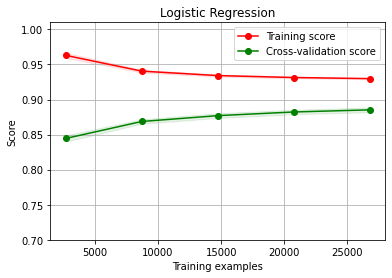

<Figure size 432x288 with 0 Axes>

In [47]:
#fig, axes = plt.subplots()
title = "Logistic Regression"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=123)
plot_learning_curve(lr_model, title, x_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()
plt.savefig('LR_learning_curve.png')

### McNemar’s test

##### Logistic regression vs. Stacking

In [52]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

y_target = np.array(y_test)
y_logistic = np.array(predicted_lr)
y_stacking = np.array(predicted_stac)

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_logistic, 
                   y_model2=y_stacking)

print(tb)

[[14563    96]
 [  107  1734]]


In [53]:
from statsmodels.stats.contingency_tables import mcnemar

# calculate mcnemar test
result = mcnemar(tb)
# summarize the finding
print('statistic=%.3f, p-value=%.5f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=96.000, p-value=0.48286
Same proportions of errors (fail to reject H0)


##### Stacking vs. Voting

In [50]:
y_target = np.array(y_test)
y_logistic = np.array(predicted_lr)
y_voting = np.array(predicted_voting)

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_logistic, 
                   y_model2=y_voting)

print(tb)

[[14293   366]
 [  296  1545]]


In [51]:
# calculate mcnemar test
result = mcnemar(tb)
# summarize the finding
print('statistic=%.3f, p-value=%.5f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=296.000, p-value=0.00728
Different proportions of errors (reject H0)
